<image src="https://i.imgur.com/r2668pf.png" width=100%>

## <font color='#4C5FDA'>**Instalamos paquetes y librerias**</font>


In [1]:
%pip install -q mat73
%pip install -q openexr
%pip install -q spectral
%pip install -q scikit-image
%pip install -q gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 2.7 MB/s eta 0:00:00


In [2]:
import mat73
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Scientific computing
import numpy as np
from scipy import io
from scipy import interpolate
from scipy.signal import gaussian

# Plotting
import matplotlib.pyplot as plt
plt.ion()

from sklearn.decomposition import PCA

## <font color='#4C5FDA'>**Descargamos la imagen hiperspectral y la libreria de firmas espectrales**</font>


In [3]:
!gdown 1L78cLVSSFLgvgGHWjGlaCPG4MzqPhYBz
!gdown 1F8qD2vwjIkFHcHwkXsVzBAPAXyH9DhyZ

Downloading...
From (original): https://drive.google.com/uc?id=1L78cLVSSFLgvgGHWjGlaCPG4MzqPhYBz
From (redirected): https://drive.google.com/uc?id=1L78cLVSSFLgvgGHWjGlaCPG4MzqPhYBz&confirm=t&uuid=c903d2a5-cf33-4491-9ce5-8f32c4770d11
To: /content/8.mat
100% 149M/149M [00:00<00:00, 243MB/s]
Downloading...
From: https://drive.google.com/uc?id=1F8qD2vwjIkFHcHwkXsVzBAPAXyH9DhyZ
To: /content/spectraldb.csv
100% 1.45M/1.45M [00:00<00:00, 112MB/s]


## <font color='#4C5FDA'>**Cargamos el cubo espectral**</font>


In [4]:
file = mat73.loadmat('./8.mat')
cube = file["rad"]

cube = cube / np.max(cube)
cube = cube.transpose(1,0 ,2)[::-1, :, :]

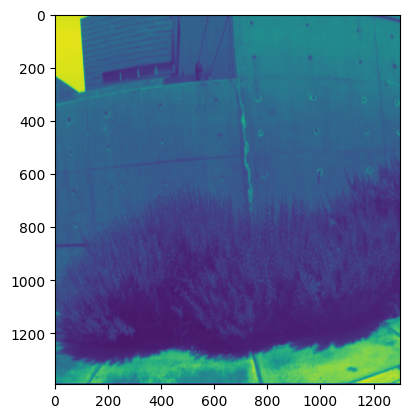

In [5]:
plt.imshow(cube[:,:,0])

## <font color='#4C5FDA'>**Metodos utiles para transformar una imagen hiperspectral a rgb**</font>


In [6]:
def g(x, alpha, mu, sigma1, sigma2):
    sigma = (x < mu)*sigma1 + (x >= mu)*sigma2
    return alpha*np.exp((x-mu)**2 / (-2*(sigma**2)))


def component_x(x): return g(x, 1.056, 5998, 379, 310) + \
    g(x, 0.362, 4420, 160, 267) + g(x, -0.065, 5011, 204, 262)


def component_y(x): return g(x, 0.821, 5688, 469, 405) + \
    g(x, 0.286, 5309, 163, 311)


def component_z(x): return g(x, 1.217, 4370, 118, 360) + \
    g(x, 0.681, 4590, 260, 138)


def xyz_from_xy(x, y):
    """Return the vector (x, y, 1-x-y)."""
    return np.array((x, y, 1-x-y))


ILUMINANT = {
    'D65': xyz_from_xy(0.3127, 0.3291),
    'E':  xyz_from_xy(1/3, 1/3),
}

COLOR_SPACE = {
    'sRGB': (xyz_from_xy(0.64, 0.33),
             xyz_from_xy(0.30, 0.60),
             xyz_from_xy(0.15, 0.06),
             ILUMINANT['D65']),

    'AdobeRGB': (xyz_from_xy(0.64, 0.33),
                 xyz_from_xy(0.21, 0.71),
                 xyz_from_xy(0.15, 0.06),
                 ILUMINANT['D65']),

    'AppleRGB': (xyz_from_xy(0.625, 0.34),
                 xyz_from_xy(0.28, 0.595),
                 xyz_from_xy(0.155, 0.07),
                 ILUMINANT['D65']),

    'UHDTV': (xyz_from_xy(0.708, 0.292),
              xyz_from_xy(0.170, 0.797),
              xyz_from_xy(0.131, 0.046),
              ILUMINANT['D65']),

    'CIERGB': (xyz_from_xy(0.7347, 0.2653),
               xyz_from_xy(0.2738, 0.7174),
               xyz_from_xy(0.1666, 0.0089),
               ILUMINANT['E']),
}


class ColourSystem:

    def __init__(self, start=None, end=None, num=None, cs='sRGB'):

        # Chromaticities
        bands = np.linspace(start=start, stop=end, num=num)*10

        self.cmf = np.array([component_x(bands),
                             component_y(bands),
                             component_z(bands)])

        self.red, self.green, self.blue, self.white = COLOR_SPACE[cs]

        # The chromaticity matrix (rgb -> xyz) and its inverse
        self.M = np.vstack((self.red, self.green, self.blue)).T
        self.MI = np.linalg.inv(self.M)

        # White scaling array
        self.wscale = self.MI.dot(self.white)

        # xyz -> rgb transformation matrix
        self.A = self.MI / self.wscale[:, np.newaxis]


    def get_transform_matrix(self):

        XYZ = self.cmf
        RGB = XYZ.T @ self.A.T
        RGB = RGB / np.sum(RGB, axis=0, keepdims=True)
        return RGB

    def spec_to_rgb(self, spec):
        """Convert a spectrum to an rgb value."""
        M = self.get_transform_matrix()
        rgb = spec @ M
        return rgb

# <font color='#4C5FDA'>**pasamos de 31 bandas a 3 bandas**</font>


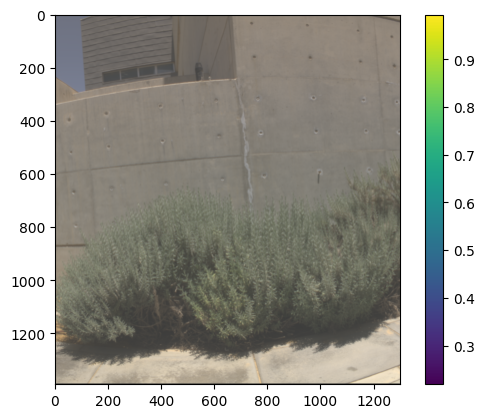

In [7]:
color_space = "sRGB"
start, end = 350, 730
number_bands = 31

cs = ColourSystem(cs=color_space, start=start, end=end, num=number_bands)

img_rgb = cs.spec_to_rgb(cube)

img_rgb = np.clip(img_rgb, 0, 1)

#post processing, because the image is too dark
img_rgb = img_rgb ** 0.5

plt.imshow(img_rgb)
plt.colorbar()
plt.show()

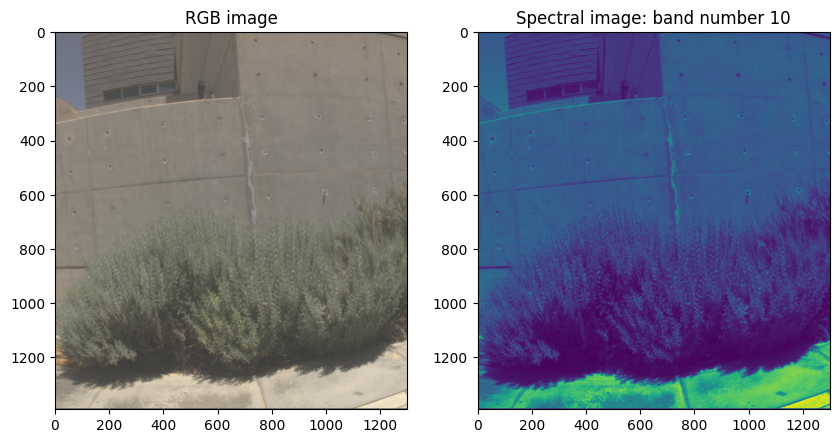

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(img_rgb)
axs[0].set_title('RGB image')

axs[1].imshow(cube[:,:,10])
axs[1].set_title('Spectral image: band number 10')

plt.show()



# <font color='#4C5FDA'>**Cargamos la libreria de firmas espectrales**</font>


In [9]:
import pandas

spectraldb = pandas.read_csv('spectraldb.csv')
print(spectraldb.columns)
print(spectraldb.shape)

Index(['ID', 'Name', 'ObjectType', 'RadianceType', 'MeasurementLocation',
       'Lat', 'Long', 'MeasurementCredit', 'URL', 'Comments', 'Specularity',
       'Roughness', 'MeasurementType', 'R', 'G', 'B', 'L', 'a', 'b', 'hex',
       'SCIMeasures', 'SCEMeasures', 'VisibleReflectance',
       'MelanopicReflectance', 'Radiance Material'],
      dtype='object')
(1288, 25)


# <font color='#4C5FDA'>**Pre-procesamos las firmas**</font>


In [10]:
spectraldb = spectraldb[spectraldb['ObjectType'] != 'Color Swatch']
print(spectraldb.shape)

(1080, 25)


In [11]:
materials = ["plant", "stone", "Aluminium", "Concrete", "Wooden", "Wood", "Metal", "Fabric", "Metallic", "grass"]

materials_dict = {word.lower(): index for index, word in enumerate(materials)}

categories = ["Wall", "Plant"]

materials_dict["wall"] = len(materials_dict)
materials_dict["plant"] = len(materials_dict)

# search for material with name that contains some string from materials list

filter1 = spectraldb["ObjectType"].str.contains('|'.join(categories), case=False)
wall_plant = spectraldb[filter1]

filter = spectraldb["Name"].str.contains('|'.join(materials), case=False)
spectraldb = spectraldb[filter]

#join two dataframes, maybe are the same row in both dataframes so we need to drop duplicates

spectraldb = pandas.concat([spectraldb, wall_plant]).drop_duplicates().reset_index(drop=True)

spectraldb

,ID,Name,ObjectType,RadianceType,MeasurementLocation,Lat,Long,MeasurementCredit,URL,Comments,...,B,L,a,b,hex,SCIMeasures,SCEMeasures,VisibleReflectance,MelanopicReflectance,Radiance Material
0,4,Light Brown Wooden Doors,Door,Plastic,"Singapore, Singapore",1.340730,103.963067,Design for Climate and Comfort Lab,NaN,Measured by SUTD undergraduate researchers Kev...,...,0.1930,69.7400,5.6900,24.0400,#C4A67F,"{360: 8.22, 370: 8.85, 380: 10.28, 390: 12.97,...","{360: 6.19, 370: 6.82, 380: 8.25, 390: 10.95, ...",0.418800,0.302020,NaN
1,17,Dark Grey Stone Tiles,Floor,Plastic,"Singapore, Singapore",1.340730,103.963067,Design for Climate and Comfort Lab,NaN,Measured by SUTD undergraduate researchers Kev...,...,0.2368,57.2300,-0.6100,2.0000,#8A8A86,"{360: 17.48, 370: 18.35, 380: 19.50, 390: 20.5...","{360: 17.25, 370: 18.12, 380: 19.28, 390: 20.3...",0.252269,0.246385,NaN
2,18,Light Grey Stone Tiles,Floor,Plastic,"Singapore, Singapore",1.340730,103.963067,Design for Climate and Comfort Lab,NaN,Measured by SUTD undergraduate researchers Kev...,...,0.2644,59.8100,-0.5100,1.9700,#91908D,"{360: 19.82, 370: 20.93, 380: 22.18, 390: 23.2...","{360: 19.67, 370: 20.79, 380: 22.06, 390: 23.1...",0.279849,0.273570,NaN
3,19,Dark Grey Stone Tiles,Floor,Plastic,"Singapore, Singapore",1.340730,103.963067,Design for Climate and Comfort Lab,NaN,Measured by SUTD undergraduate researchers Kev...,...,0.2528,58.6600,-0.6800,1.8500,#8D8D8A,"{360: 18.05, 370: 19.25, 380: 20.60, 390: 21.8...","{360: 17.86, 370: 19.06, 380: 20.41, 390: 21.7...",0.267221,0.261962,NaN
4,20,Yellow Painted Stone Tiles,Floor,Plastic,"Singapore, Singapore",1.340730,103.963067,Design for Climate and Comfort Lab,NaN,Measured by SUTD undergraduate researchers Kev...,...,0.0299,75.2400,19.4700,63.9900,#F7A93E,"{360: 5.78, 370: 6.35, 380: 7.31, 390: 8.46, 4...","{360: 5.64, 370: 6.22, 380: 7.18, 390: 8.34, 4...",0.532006,0.180308,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,1258,White Wall 5,Wall,Plastic,Singapore,1.345842,103.858408,"Design for Climate and Comfort Lab, SUTD",NaN,Measurements taken at classrooms at BCA Academ...,...,0.8389,95.2600,-1.1200,2.4000,#F1F2ED,"{400: 48.71, 410: 70.10, 420: 81.06, 430: 84.1...","{400: 48.09, 410: 69.41, 420: 80.31, 430: 83.3...",0.883479,0.872607,NaN
418,1265,Light Yellow Wall,Wall,Plastic,Singapore,1.345842,103.858408,"Design for Climate and Comfort Lab, SUTD",NaN,Measurements taken at classrooms at BCA Academ...,...,0.6528,90.8900,0.0700,8.9000,#ECE4D4,"{400: 38.46, 410: 54.40, 420: 61.84, 430: 64.5...","{400: 38.20, 410: 54.13, 420: 61.56, 430: 64.2...",0.790855,0.720563,NaN
419,1292,White Plaster Wall CH,Wall,Plastic,"Lausanne, Switzerland",46.519100,6.566000,Clotilde Pierson,NaN,Measurements collected in the EPFL Demona labo...,...,0.8121,94.5686,-0.7471,3.3864,#F1F0E9,"{380: 43.81, 390: 43.81, 400: 43.81, 410: 67.1...","{380: 43.56, 390: 43.56, 400: 43.56, 410: 66.8...",0.866943,0.843689,NaN
420,1293,White Plaster Wall NL,Wall,Plastic,"Eindhoven, Netherlands",51.448600,5.490700,Clotilde Pierson,NaN,Measurements collected in the TU/E daylighting...,...,0.7076,91.4610,-1.3654,6.1441,#E9E7DB,"{360: 7.27, 370: 8.91, 380: 12.81, 390: 22.68,...","{360: 7.27, 370: 8.90, 380: 12.84, 390: 22.73,...",0.796578,0.752997,NaN


In [12]:
wv_int = np.array(list(range(420, 730, 10))) # desde la longitud de onda 420 a la 730 cada 10 nm
wv_int.shape

(31,)

## <font color='#4C5FDA'>**Plot de todas las firmas espectrales de materiales**</font>


(370, 31)


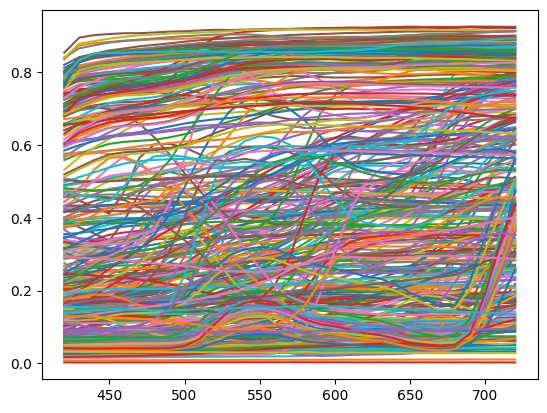

In [13]:
data = []


remove_signatures = []

for row in spectraldb.itertuples():
    SCEdict = eval(row.SCEMeasures)
    try:
        reflectances = np.array([SCEdict[wavelength] for wavelength in wv_int]) / 100
    except KeyError:
        remove_signatures.append(row.Index)
        continue
    #if row.ObjectType not in objects.keys():
    #    objects[row.ObjectType] = len(objects)

    data.append(reflectances)

    plt.plot(wv_int, reflectances)

spectraldb.drop(remove_signatures, inplace=True)

print(np.array(data).shape)

# <font color='#4C5FDA'>**Plot de firmas separado por material**</font>


plant 35
stone 17
aluminium 16
concrete 37
wooden 53
wood 84
metal 32
fabric 19
metallic 5
grass 17
wall 148


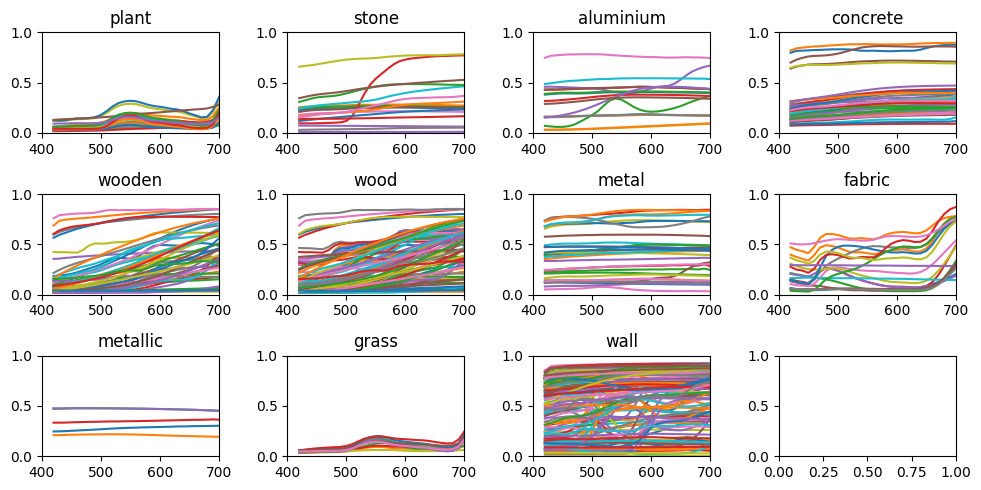

In [14]:
fig, ax = plt.subplots(3, 4, figsize=(10, 5))

for i,material in enumerate(materials_dict.keys()):
    filter = spectraldb["Name"].str.contains(material, case=False)
    material_df = spectraldb[filter]

    filter1 = spectraldb["ObjectType"].str.contains(material, case=False)
    material_df_ = spectraldb[filter1]

    signatures_mat = pandas.concat([material_df, material_df_]).drop_duplicates().reset_index()

    print(material, signatures_mat.shape[0])

    for row in signatures_mat.itertuples():
        SCEdict = eval(row.SCEMeasures)
        reflectances = np.array([SCEdict[wavelength] for wavelength in wv_int]) / 100
        ax[i//4, i%4].plot(wv_int, reflectances)
        ax[i//4, i%4].set_title(material)
        ax[i//4, i%4].set_ylim([0, 1])
        ax[i//4, i%4].set_xlim([400, 700])

plt.tight_layout()
plt.show()


In [15]:
materials_matrix = np.array(data)
materials_matrix.shape

(370, 31)

## <font color='#4C5FDA'>**Calculamos los angulos espectrales para cada material con respecto a cada pixel en el cubo**</font>


In [16]:
import spectral

result_sam = spectral.algorithms.spectral_angles(cube[600:,:,:], materials_matrix)

In [17]:
result_sam.shape

(792, 1300, 370)

In [18]:
def plot_2_signatures(signature1, signature2):
    plt.plot(wv_int, signature1, label='signature1')
    plt.plot(wv_int, signature2, label='signature2')

def plot_nearest_signature(nearest_matrix, x, y):
    material = nearest_matrix[x,y]
    row = spectraldb.iloc[material, :]
    signature = np.array([eval(row.SCEMeasures)[wavelength] for wavelength in wv_int]) / 100
    plot_2_signatures(cube[x,y,:], signature)
    plt.legend()
    plt.show()

In [19]:


a = np.argmin(result_sam, axis=2)
a.shape

(792, 1300)

In [20]:
cube[600:,:,:].shape

(792, 1300, 31)

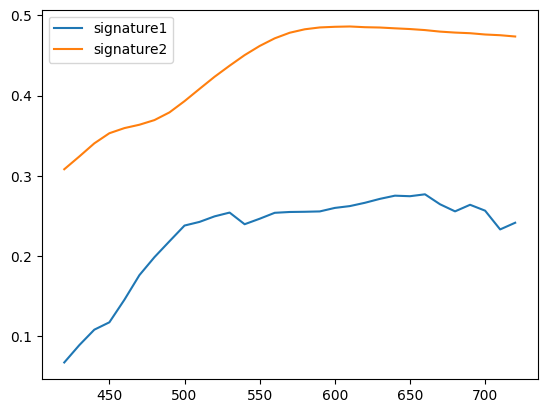

In [24]:
plot_nearest_signature(a, 500, 1299)

In [27]:
segmentation_materials = np.zeros((cube[600:,:,:].shape[0], cube.shape[1]), dtype=np.uint32)

for i in range(cube[600:,:,:].shape[0]):
    for j in range(cube.shape[1]):
        material = a[i,j]
        row = spectraldb.iloc[material, :]

        material = str(row.Name)
        real_material =[category.lower() for category in materials if category.lower() in material.lower()]
        if len(real_material) == 0:
            real_material =[category.lower() for category in categories if category.lower() in row.ObjectType.lower()]

        segmentation_materials[i,j] = materials_dict[real_material[0]]
        #segmentation_materials[i,j] = objects[str(row.ObjectType)] #material


In [38]:
segmentation_materials.shape

(792, 1300)

In [28]:
materials_dict

{'plant': 11,
 'stone': 1,
 'aluminium': 2,
 'concrete': 3,
 'wooden': 4,
 'wood': 5,
 'metal': 6,
 'fabric': 7,
 'metallic': 8,
 'grass': 9,
 'wall': 10}

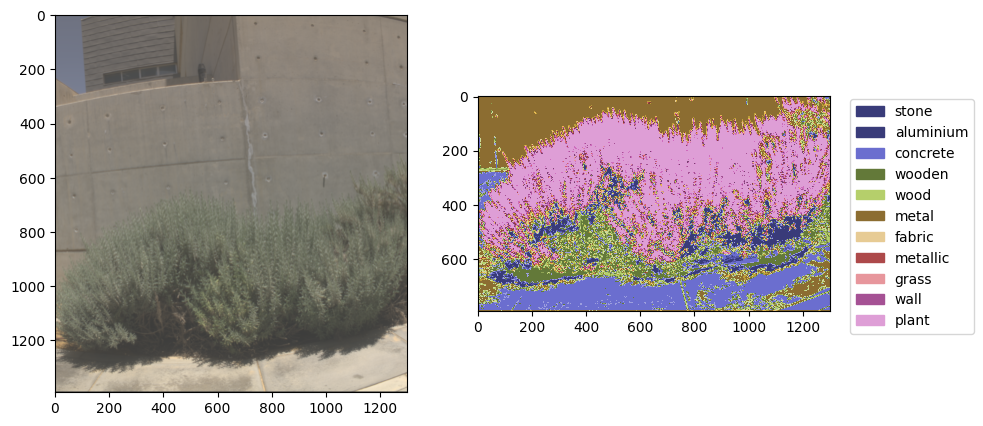

In [29]:
import matplotlib.patches as mpatches
import matplotlib

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

colors = ['olive','red', 'green', 'yellow', 'pink', 'orange', 'purple', 'brown', 'gray', 'cyan']
vmin = None
vmax = None
cmap = matplotlib.colors.ListedColormap(colors)


im = ax[1].imshow(segmentation_materials, cmap="tab20b")

values = list(range(11))
names = list(materials_dict.keys())

colors = [ im.cmap(im.norm(value)) for value in values]



aa = [ mpatches.Patch(color=colors[i], label=f"{list(materials_dict.keys())[list(materials_dict.values()).index(i+1)]}") for i in range(0,11) ]


plt.legend(handles=aa, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)

ax[0].imshow(img_rgb)

plt.show()

In [30]:
materials_dict

{'plant': 11,
 'stone': 1,
 'aluminium': 2,
 'concrete': 3,
 'wooden': 4,
 'wood': 5,
 'metal': 6,
 'fabric': 7,
 'metallic': 8,
 'grass': 9,
 'wall': 10}

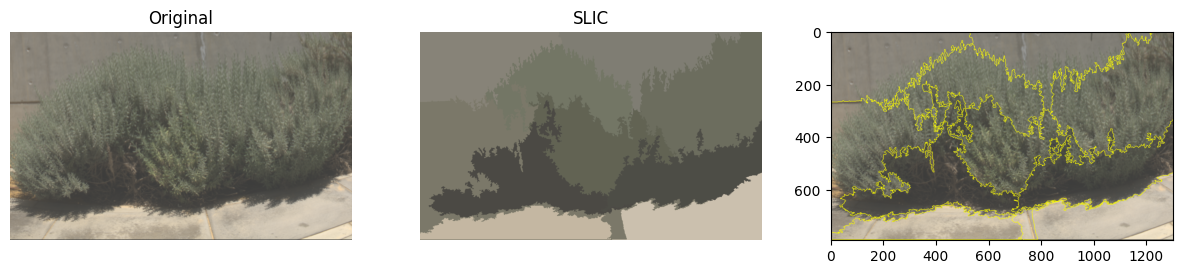

In [36]:
from skimage import data, segmentation, color

# labels_slic = segmentation.slic(img_rgb, compactness=None, n_segments=11)
labels_slic = segmentation.slic(img_rgb[600:,:,:], n_segments=11)
superpixels_slic = color.label2rgb(labels_slic, img_rgb[600:,:,:], kind='avg')

# show original image, slic, ground truth
fig, ax = plt.subplots(1,3, figsize=(15,10))
ax[0].imshow(img_rgb[600:,:,:])
ax[0].set_title("Original")
ax[0].axis('off')
ax[1].imshow(superpixels_slic)
ax[1].set_title("SLIC")
ax[1].axis('off')
ax[2].imshow(segmentation.mark_boundaries(img_rgb[600:,:,:], labels_slic))

In [37]:
def sp_idx(s, index = True):
     u = np.unique(s)
     return [np.where(s == i) for i in u], u.shape[0]

superpixel_list, n = sp_idx(labels_slic)

for i in range(n):
     superpixel = superpixel_list[i]
     objects_ = []
     for j in range(len(superpixel[0])):
          x = i
          y = j
          objects_.append(segmentation_materials[x,y])
     max_object = max(set(objects_), key=objects_.count)
     for j in range(len(superpixel[0])):
          x = i
          y = j
          segmentation_materials[x,y] = max_object

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
im = ax[1].imshow(segmentation_materials, cmap='tab20b')

values = list(range(13))
names = list(materials_dict.keys())
colors = [ im.cmap(im.norm(value)) for value in values]
aa = [ mpatches.Patch(color=colors[i], label=f"{list(materials_dict.keys())[list(materials_dict.values()).index(i+1)]}") for i in range(0,11) ]
plt.legend(handles=aa, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)

ax[0].imshow(img_rgb)

plt.show()

IndexError: index 1300 is out of bounds for axis 1 with size 1300

In [ ]:
segmentation.shape

AttributeError: module 'skimage.segmentation' has no attribute 'shape'